In [1]:
# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org -U econml

In [1]:
import datetime
import time
import math
import pandas as pd
import ast
import re, string, unicodedata
import copy
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.sql import functions as f
from pyspark.sql.functions import row_number
from pyspark.sql import types
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, countDistinct,concat
import os
import subprocess

pd.set_option('display.max_rows', 200)

/data/2/parcels/SPARK2-2.2.0.cloudera4-1.cdh5.13.3.p0.603055/lib/spark2/python/pyspark/cloudpickle.py:366: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


### Assign Variables

In [3]:
#Cohort and related dates
MMYYYY = '072022'
cohort = '2022-07-31'
cohort_date = datetime.strptime(cohort, '%Y-%m-%d').date()
cohort_treat_stdt = str(cohort_date.replace(day=1))
print("Cohort: ", cohort)
print("Cohort Treatment Start Date: ", cohort_treat_stdt)

#post treatment end date (i.e. 6 months post-treatment month)
pt_enddt_date = cohort_date + relativedelta(months=+6)
pt_enddt = str(pt_enddt_date)
print("Post Treatment Attrition Window End Date: ", pt_enddt)

#post treatment start date (i.e. 1 month post-treatment month)
pt_stdt_date = cohort_date + relativedelta(months=+1)
pt_stdt = str(pt_stdt_date)
print("Post Treatment Attrition Window Start Date: ", pt_stdt)

#ptrstdt = pre treatment start date (i.e. 12 months pre-treatment month (inclusive of treatment month) for feature extraction)
prt_stdt_date = cohort_date + relativedelta(months=-12)
prt_stdt = str(prt_stdt_date)
print("Pre Treatment Data Collection Period Start Date: ", prt_stdt)

#prt_ntdt = no trade date (i.e. 6 months pre-treatment month (inclusive of treatment month))
prt_ntdt_date = cohort_date + relativedelta(months=-6)
prt_ntdt = str(prt_ntdt_date)
print("Pre-Treatment No Trade Activity Start Date: ", prt_ntdt)


Cohort:  2022-07-31
Cohort Treatment Start Date:  2022-07-01
Post Treatment Attrition Window End Date:  2023-01-31
Post Treatment Attrition Window Start Date:  2022-08-31
Pre Treatment Data Collection Period Start Date:  2021-07-31
Pre-Treatment No Trade Activity Start Date:  2022-01-31


In [4]:
#Create the connection to hadoop cluster
appname='abc'
spark = (SparkSession.builder.appName(appname)
.enableHiveSupport().getOrCreate())

### Data Extraction: Base Cohort Population, Already Attrited, Newly Attrited, Treatment Status

In [6]:
#Base Cohort

#Flag for traded in the past X months criteria
cohort_traded_criteria = spark.sql("""
Select a.*
        , b.`traded_criteria_flag`
from
(SELECT cust_id
        , '{MMYYYY}' as treatment_month
        , efectv_dt
        , invest_cust_di_aua_split_yymm 
        , trx_cust_di_sell_trade_num_cons_yymm + trx_cust_di_buy_trade_num_cons_yymm as di_trades
from 
where client_edw_cust_di_flag = 1 and client_cust_person_flag = 1 
    and client_cust_death_date IS NULL and efectv_dt = '{cohort}') a
left join (SELECT cust_id
                , max(case when trx_cust_di_sell_trade_num_cons_yymm + trx_cust_di_buy_trade_num_cons_yymm > 0 then 1
                    else 0 end) as traded_criteria_flag
            from advanced_analytics.wealth360_customer_level_mastertable_v2
            where client_edw_cust_di_flag = 1 and client_cust_person_flag = 1 
                and client_cust_death_date IS NULL and efectv_dt >= '{prt_ntdt}' and efectv_dt <= '{cohort}'
            group by cust_id) b
on a.cust_id = b.cust_id
""".format(MMYYYY=MMYYYY, cohort=cohort, prt_ntdt=prt_ntdt))

#de-duping from the feature store
cohort_traded_criteria = cohort_traded_criteria.distinct()
cohort_traded_criteria.createOrReplaceTempView("cohort_traded_criteria")

#How many clients already attrited in the cohort month? i.e. exclusion criteria

cohort_already_attrited = spark.sql("""
select a.cust_id as already_attrited_cust_ids
from cohort_traded_criteria a
join (SELECT a.cust_id, c.score_intercept AS engagement_score
            FROM cohort_traded_criteria a
            LEFT JOIN (SELECT gold_id, cust_id 
                    FROM dip_db.prod_stg_gold_cust_acct_oozie
                    GROUP BY gold_id, cust_id
                    ) b
            ON a.cust_id = b.cust_id
            LEFT JOIN (SELECT gold_id, score_intercept
                    FROM dip_db.prod_stg_es_metrics_scored_oozie
                    WHERE yearmonth = '{cohort}'
                    ) c
            ON b.gold_id = c.gold_id) b
    on a.cust_id = b.cust_id and b.engagement_score = 0
where a.invest_cust_di_aua_split_yymm <= 0 and a.traded_criteria_flag = 0
""".format(cohort=cohort))
cohort_already_attrited.createOrReplaceTempView("cohort_already_attrited")

#Remove already attrited from base cohort data (i.e. exclude these clients from the study as they're already attrited in the cohort month!)
cohort_base_clients = spark.sql("""
select a.cust_id
        ,a.treatment_month
        ,a.efectv_dt
    from cohort_traded_criteria a
    left join cohort_already_attrited b on a.cust_id = b.already_attrited_cust_ids
    where b.already_attrited_cust_ids is null
""")
cohort_base_clients.createOrReplaceTempView("cohort_base_clients")

#How many clients are newly attrited, starting from the month after the treatmonth month and ending 6months after this month
#when checking trade activity criteria. I.e. for the July 2022 cohort, clients must have 0 trading activity 
#from Aug 2022 to Jan 2023.

#data at the end of the post treatment period - base (cohort) clients that satisify the trading and aua criteria for attrited
cohort_pt_end1 = spark.sql("""
Select a.*
from (SELECT x.*
            , y.efectv_dt as pt_enddt
            , y.invest_cust_di_aua_split_yymm 
            , y.trx_cust_di_sell_trade_num_cons_yymm + trx_cust_di_buy_trade_num_cons_yymm as di_trades
        from cohort_base_clients x
        join advanced_analytics.wealth360_customer_level_mastertable_v2 y on x.cust_id = y.cust_id
        where y.efectv_dt = '{pt_enddt}') a
left join (SELECT cust_id
                , max(case when trx_cust_di_sell_trade_num_cons_yymm + trx_cust_di_buy_trade_num_cons_yymm > 0 then 1
                    else 0 end) as traded_criteria_flag
            from advanced_analytics.wealth360_customer_level_mastertable_v2
            where client_edw_cust_di_flag = 1 and client_cust_person_flag = 1 
                and client_cust_death_date IS NULL and efectv_dt >= '{pt_stdt}' and efectv_dt <= '{pt_enddt}'
            group by cust_id) b
on a.cust_id = b.cust_id
where b.traded_criteria_flag = 0 and a.invest_cust_di_aua_split_yymm <= 0
""".format(pt_enddt=pt_enddt,pt_stdt=pt_stdt))

#De-dupe
cohort_pt_end1 = cohort_pt_end1.distinct()
cohort_pt_end1.createOrReplaceTempView("cohort_pt_end1")

#Add engagement score to finalize base cohort clients that attrited at the end of the post treatment period
cohort_pt_end_attrited = spark.sql("""
select a.cust_id as pt_end_attrited_ids
from cohort_pt_end1 a
join (SELECT a.cust_id, c.score_intercept AS engagement_score
            FROM cohort_pt_end1 a
            LEFT JOIN (SELECT gold_id, cust_id 
                    FROM dip_db.prod_stg_gold_cust_acct_oozie
                    GROUP BY gold_id, cust_id
                    ) b
            ON a.cust_id = b.cust_id
            LEFT JOIN (SELECT gold_id, score_intercept
                    FROM dip_db.prod_stg_es_metrics_scored_oozie
                    WHERE yearmonth = '{pt_enddt}'
                    ) c
            ON b.gold_id = c.gold_id) b
    on a.cust_id = b.cust_id and b.engagement_score = 0
""".format(pt_enddt=pt_enddt))
cohort_pt_end_attrited.createOrReplaceTempView("cohort_pt_end_attrited")

#Add attrited post-treatment flag to base clients
cohort_base_clients_att_flag = spark.sql("""
select a.*
        ,case when b.pt_end_attrited_ids is null then 0 else 1 end as attrited_pt_flag
from cohort_base_clients a
left join cohort_pt_end_attrited b on a.cust_id = b.pt_end_attrited_ids
""")
cohort_base_clients_att_flag.createOrReplaceTempView("cohort_base_clients_att_flag")

#Add MT consumption status as treatment indicator
cohort_base_treatment_ind = spark.sql("""
select a.*
        , case when b.cust_key is not null then 1 else 0 end as treatment_status
        , case when b.MT_consumption_count_treatment_month is null then 0 else b.MT_consumption_count_treatment_month end as MT_consumption_count_treatment_month
from cohort_base_clients_att_flag a
left join (select cust_key
                 ,count(1) as MT_consumption_count_treatment_month
            from dip_db.prod_stg_moneytalk_details_oozie
            where cust_key_type = 'CUST_ID' and efectv_dt>= '{cohort_treat_stdt}' and efectv_dt<='{cohort}'
                and (lower(page_url) like '/www.moneytalkgo.com/%' and lower(page_url) not like '/www.moneytalkgo.com/')
            group by cust_key) b 
on a.cust_id = b.cust_key

""".format(cohort_treat_stdt=cohort_treat_stdt,cohort=cohort))
cohort_base_treatment_ind.createOrReplaceTempView("cohort_base_treatment_ind")

In [40]:
a = spark.sql("""
select treatment_status
        ,attrited_pt_flag
        ,count(1) as count
from cohort_base_treatment_ind
group by treatment_status
        ,attrited_pt_flag
""")
a.show()

+----------------+----------------+-------+
|treatment_status|attrited_pt_flag|  count|
+----------------+----------------+-------+
|               1|               0|  33522|
|               1|               1|    206|
|               0|               0|1346007|
|               0|               1|  67781|
+----------------+----------------+-------+



In [8]:
#Save baseline table to HEAT
drop=spark.sql("drop table if exists advanced_analytics.mt_retention_tr_outcome_base_{MMYYYY}".format(MMYYYY=MMYYYY))
write=spark.sql("""create table if not exists advanced_analytics.mt_retention_tr_outcome_base_{MMYYYY} as 
                    select * from cohort_base_treatment_ind""".format(MMYYYY=MMYYYY))

## Data Extraction: Client Features

In [8]:
# #Extract Data from HEAT when re-running code
# cohort_base_treatment_ind = spark.sql("""select * from advanced_analytics.mt_retention_tr_outcome_base_{MMYYYY}""".format(MMYYYY=MMYYYY))
# cohort_base_treatment_ind.createOrReplaceTempView("cohort_base_treatment_ind")

### Features that can be extracted directly from the cohort month's data

In [11]:
cohort_month_features1 = spark.sql("""
select a.* 
    ,client_cust_new_wallet_size
    ,client_cust_share_of_wallet
    ,client_cust_new_wallet_size_band
    ,client_edw_cust_retail_balance
    ,client_cust_retail_flag
    ,client_cust_non_registered_account_flag
    ,client_cust_wealth_registered_account_flag
    ,client_cust_num_product_families
    ,client_cust_num_active_accounts
    ,client_cust_num_retail_active_accounts
    ,client_cust_num_active_accounts - client_cust_num_retail_active_accounts as client_cust_num_nonretail_active_accounts
    ,client_cust_retail_lending_flag
    ,client_cust_retail_savings_investment_flag
    ,client_cust_retail_mf_flag
    ,client_cust_retail_term_deposit_flag
    ,client_cust_retail_investment_other_flag
    ,client_cust_wealth_customer_tenure_months
    ,client_cust_age_yr
    ,client_cust_num_web_access_services
    ,client_cust_new_wealth_customer_flag
    ,client_cust_td_customer_tenure_months
    ,client_cust_num_products
    ,client_cust_gross_income
    ,invest_cust_DI_Acct_num_yymm
    ,invest_cust_di_tfsa_acct_flag_yymm
    ,invest_cust_di_aua_split_yymm
    ,invest_cust_FP_Acct_num_yymm + invest_cust_PIA_Acct_num_yymm + invest_cust_PIC_Acct_num_yymm as invest_cust_Advice_Acct_num_yymm
    ,invest_cust_FP_aua_split_yymm + invest_cust_PIA_aua_split_yymm + invest_cust_PIC_aua_split_yymm as invest_cust_Advice_aua_split_yymm
    ,client_edw_cust_retail_mortgage_mob + client_edw_cust_retail_loan_mob + client_edw_cust_retail_loc_mob + client_edw_cust_retail_creditcard_mob as client_edw_cust_retail_moneyout_balance
from cohort_base_treatment_ind a
join advanced_analytics.wealth360_customer_level_mastertable_v2 b on a.cust_id = b.cust_id
where b.efectv_dt = '{cohort}'
""".format(cohort=cohort))

#de-dupe pulled records from feature store
cohort_month_features1 = cohort_month_features1.distinct()
cohort_month_features1.createOrReplaceTempView("cohort_month_features1")

# #add account level feature - i.e. EasyTrade account flag
# cohort_month_features2 = spark.sql("""
# select a.*
#         , case when b.client_cust_easytrade_account_flag is null then 0 else 1 end as client_cust_easytrade_account_flag
# from cohort_month_features1 a
# left join ( select cust_id
#             , max(account_flag) as client_cust_easytrade_account_flag
#         from advanced_analytics.wealth360_all_customers_baseline
#         where rr_code like 'RY%' and account_flag = 1 and efectv_dt = '{cohort}' 
#             and (account_close_date = '' or account_close_date is null)
#         group by cust_id
#         ) b on a.cust_id = b.cust_id

# """.format(cohort=cohort))
# cohort_month_features2.createOrReplaceTempView("cohort_month_features2")


#add engagement_score at the end of the month before the cohort month (to avoid target leakage)
cohort_month_features = spark.sql("""
select a.*
        ,b.engagement_score as cohort_month_es
from cohort_month_features1 a
left join (SELECT a.cust_id
                , c.score_intercept as engagement_score
        FROM cohort_base_treatment_ind a
        LEFT JOIN (SELECT gold_id, cust_id 
                FROM dip_db.prod_stg_gold_cust_acct_oozie
                GROUP BY gold_id, cust_id
                ) b
        ON a.cust_id = b.cust_id
        LEFT JOIN (SELECT gold_id, yearmonth, score_intercept
                FROM dip_db.prod_stg_es_metrics_scored_oozie
                WHERE yearmonth = add_months('{cohort}', -1) 
                ) c
        ON b.gold_id = c.gold_id) b on a.cust_id = b.cust_id

""".format(cohort=cohort))
cohort_month_features.createOrReplaceTempView("cohort_month_features")

### Features requiring the past 12 months' of data to aggregate

In [12]:
#Some longer calculated features
ofi_td_debit_total = """ofi_tdct_debit_wealthsimple_transfer_amt_yymm +
                        ofi_tdct_debit_wealthsimple_or_questtrade_transfer_amt_yymm +
                        ofi_tdct_debit_qtrade_transfer_amt_yymm +
                        ofi_tdct_debit_interactivebrokers_transfer_amt_yymm +
                        ofi_tdct_debit_ci_investment_transfer_amt_yymm +
                        ofi_tdct_debit_ig_financial_transfer_amt_yymm +
                        ofi_tdct_debit_rbc_wealth_mgmt_transfer_amt_yymm +
                        ofi_tdct_debit_rbc_di_transfer_amt_yymm +
                        ofi_tdct_debit_td_waterhouse_transfer_amt_yymm +
                        ofi_tdct_debit_cibc_di_transfer_amt_yymm +
                        ofi_tdct_debit_cibc_investor_transfer_amt_yymm +
                        ofi_tdct_debit_bmo_investorline_transfer_amt_yymm +
                        ofi_tdct_debit_cibc_general_transfer_amt_yymm +
                        ofi_tdct_debit_rbc_general_transfer_amt_yymm +
                        ofi_tdct_debit_bmo_general_transfer_amt_yymm +
                        ofi_tdct_debit_manulife_general_transfer_amt_yymm +
                        ofi_tdct_debit_desjardins_general_transfer_amt_yymm +
                        ofi_tdct_debit_tangerine_general_transfer_amt_yymm +
                        ofi_tdct_debit_scotiabank_general_transfer_amt_yymm +
                        ofi_tdct_debit_fidelity_general_transfer_amt_yymm +
                        ofi_tdct_debit_scotia_itrade_transfer_amt_yymm +
                        ofi_tdct_debit_scotiamcleod_di_transfer_amt_yymm +
                        ofi_tdct_debit_national_transfer_amt_yymm
                        
                        """

ofi_td_credit_total = """ofi_tdct_credit_questtrade_transfer_amt_yymm +
                        ofi_tdct_credit_wealthsimple_transfer_amt_yymm +
                        ofi_tdct_credit_wealthsimple_or_questtrade_transfer_amt_yymm +
                        ofi_tdct_credit_qtrade_transfer_amt_yymm +
                        ofi_tdct_credit_interactivebrokers_transfer_amt_yymm +
                        ofi_tdct_credit_ci_investment_transfer_amt_yymm +
                        ofi_tdct_credit_ig_financial_transfer_amt_yymm +
                        ofi_tdct_credit_rbc_wealth_mgmt_transfer_amt_yymm +
                        ofi_tdct_credit_rbc_di_transfer_amt_yymm +
                        ofi_tdct_credit_td_waterhouse_transfer_amt_yymm +
                        ofi_tdct_credit_cibc_di_transfer_amt_yymm +
                        ofi_tdct_credit_cibc_investor_transfer_amt_yymm +
                        ofi_tdct_credit_bmo_investorline_transfer_amt_yymm +
                        ofi_tdct_credit_cibc_general_transfer_amt_yymm +
                        ofi_tdct_credit_rbc_general_transfer_amt_yymm +
                        ofi_tdct_credit_bmo_general_transfer_amt_yymm +
                        ofi_tdct_credit_manulife_general_transfer_amt_yymm +
                        ofi_tdct_credit_desjardins_general_transfer_amt_yymm +
                        ofi_tdct_credit_tangerine_general_transfer_amt_yymm +
                        ofi_tdct_credit_scotiabank_general_transfer_amt_yymm +
                        ofi_tdct_credit_fidelity_general_transfer_amt_yymm +
                        ofi_tdct_credit_scotia_itrade_transfer_amt_yymm +
                        ofi_tdct_credit_scotiamcleod_di_transfer_amt_yymm +
                        ofi_tdct_credit_national_transfer_amt_yymm
                        
                        """

In [13]:
#Features obtainable from the feature store
past_12_mo_features = spark.sql("""
select a.cust_id
        ,b.efectv_dt 
        , digital_re_visit_num_yymm
        , digital_re_visit_day_count_yymm
        , digital_lc_visit_num_yymm
        , digital_lc_visit_day_count_yymm
        , digital_edu_visit_num_yymm
        , digital_edu_visit_day_count_yymm
        , digital_qw_visit_num_yymm
        , digital_qw_visit_day_count_yymm
        , digital_login_visit_num_yymm
        , digital_login_distinct_visit_num_yymm
        , Trx_cust_DI_Contribution_Amt_Cons_yymm
        , trx_cust_di_sell_trade_num_cons_yymm + trx_cust_di_buy_trade_num_cons_yymm as di_trades
        , Trx_cust_DI_Nag_Amt_Cons_yymm
        , {ofi_td_debit_total} as ofi_td_debit_total
        , {ofi_td_credit_total} as ofi_td_credit_total
from cohort_base_treatment_ind a
join advanced_analytics.wealth360_customer_level_mastertable_v2 b on a.cust_id = b.cust_id
and b.efectv_dt >= '{prt_stdt}' and b.efectv_dt <= '{cohort}'
""".format(cohort=cohort, prt_stdt=prt_stdt, ofi_td_debit_total=ofi_td_debit_total, ofi_td_credit_total=ofi_td_credit_total))

#de-dupe pulled records from feature store
past_12_mo_features = past_12_mo_features.distinct()
#past_12_mo_features = past_12_mo_features.dropDuplicates(['cust_id', 'efectv_dt'])
past_12_mo_features.createOrReplaceTempView("past_12_mo_features")

#Do not include the treatment month for MT visit history metrics to avoid target leakage. Pull and group this feature at cust_id level
past_mt_visits_history = spark.sql("""
select a.cust_id
        , b.efectv_dt
        , digital_mt_visit_num_yymm
        , digital_mt_visit_day_count_yymm
from cohort_base_treatment_ind a
join advanced_analytics.wealth360_customer_level_mastertable_v2 b on a.cust_id = b.cust_id
and b.efectv_dt >= '{prt_stdt}' and b.efectv_dt <= add_months('{cohort}', -1)
""".format(prt_stdt=prt_stdt, cohort=cohort))
past_mt_visits_history = past_mt_visits_history.distinct()
past_mt_visits_history.createOrReplaceTempView("past_mt_visits_history")

past_mt_visits_history_grouped = spark.sql("""
select cust_id
        , avg(digital_mt_visit_num_yymm) as digital_mt_visit_num_yymm
        , avg(digital_mt_visit_day_count_yymm) as digital_mt_visit_day_count_yymm
from past_mt_visits_history
group by cust_id
""")
past_mt_visits_history_grouped.createOrReplaceTempView("past_mt_visits_history_grouped")

#Average past 12 months' engagement score (excluding cohort month due to target leakage issues - engagement score considers MT)
past_12_mo_avg_es = spark.sql("""
        SELECT a.cust_id
                , avg(c.score_intercept) as engagement_score
        FROM cohort_base_treatment_ind a
        LEFT JOIN (SELECT gold_id, cust_id 
                FROM dip_db.prod_stg_gold_cust_acct_oozie
                GROUP BY gold_id, cust_id
                ) b
        ON a.cust_id = b.cust_id
        LEFT JOIN (SELECT gold_id, yearmonth, score_intercept
                FROM dip_db.prod_stg_es_metrics_scored_oozie
                WHERE yearmonth >= '{prt_stdt}' and yearmonth < '{cohort}'
                ) c
        ON b.gold_id = c.gold_id
        group by a.cust_id
""".format(cohort=cohort, prt_stdt=prt_stdt))
past_12_mo_avg_es.createOrReplaceTempView("past_12_mo_avg_es")

#Aggregate past 12 month features on an average monthly level and add engagement score
past_12_mo_features_agg1 = spark.sql("""
select a.*
        ,b.engagement_score as avg_monthly_es
from ( select cust_id
                , avg(digital_re_visit_num_yymm) as digital_re_visit_num_yymm
                , avg(digital_re_visit_day_count_yymm) as digital_re_visit_day_count_yymm
                , avg(digital_lc_visit_num_yymm) as digital_lc_visit_num_yymm
                , avg(digital_lc_visit_day_count_yymm) as digital_lc_visit_day_count_yymm
                , avg(digital_edu_visit_num_yymm) as digital_edu_visit_num_yymm
                , avg(digital_edu_visit_day_count_yymm) as digital_edu_visit_day_count_yymm
                , avg(digital_qw_visit_num_yymm) as digital_qw_visit_num_yymm
                , avg(digital_qw_visit_day_count_yymm) as digital_qw_visit_day_count_yymm
                , avg(digital_login_visit_num_yymm) as digital_login_visit_num_yymm
                , avg(digital_login_distinct_visit_num_yymm) as digital_login_distinct_visit_num_yymm
                , avg(Trx_cust_DI_Contribution_Amt_Cons_yymm) as Trx_cust_DI_Contribution_Amt_Cons_yymm
                , avg(di_trades) as di_trades
                , avg(Trx_cust_DI_Nag_Amt_Cons_yymm) as Trx_cust_DI_Nag_Amt_Cons_yymm
                , avg(ofi_td_debit_total) as ofi_td_debit_total
                , avg(ofi_td_credit_total) as ofi_td_credit_total
            from past_12_mo_features
            group by cust_id
            ) a
left join past_12_mo_avg_es b on a.cust_id = b.cust_id
""")
past_12_mo_features_agg1.createOrReplaceTempView("past_12_mo_features_agg1")

past_12_mo_features_agg = spark.sql("""
select a.*
        ,b.digital_mt_visit_num_yymm
        ,b.digital_mt_visit_day_count_yymm
from past_12_mo_features_agg1 a
join past_mt_visits_history_grouped b on a.cust_id = b.cust_id
""")
past_12_mo_features_agg.createOrReplaceTempView("past_12_mo_features_agg")

In [23]:
past_12_mo_features_agg.dtypes

[('cust_id', 'bigint'),
 ('digital_re_visit_num_yymm', 'double'),
 ('digital_re_visit_day_count_yymm', 'double'),
 ('digital_lc_visit_num_yymm', 'double'),
 ('digital_lc_visit_day_count_yymm', 'double'),
 ('digital_edu_visit_num_yymm', 'double'),
 ('digital_edu_visit_day_count_yymm', 'double'),
 ('digital_qw_visit_num_yymm', 'double'),
 ('digital_qw_visit_day_count_yymm', 'double'),
 ('digital_login_visit_num_yymm', 'double'),
 ('digital_login_distinct_visit_num_yymm', 'double'),
 ('Trx_cust_DI_Contribution_Amt_Cons_yymm', 'decimal(38,6)'),
 ('di_trades', 'double'),
 ('Trx_cust_DI_Nag_Amt_Cons_yymm', 'decimal(38,6)'),
 ('ofi_td_debit_total', 'decimal(38,12)'),
 ('ofi_td_credit_total', 'decimal(38,12)'),
 ('avg_monthly_es', 'decimal(38,21)'),
 ('digital_mt_visit_num_yymm', 'double'),
 ('digital_mt_visit_day_count_yymm', 'double')]

### Adding all features together

In [14]:
features_final = spark.sql("""
select a.*
        , avg_monthly_es
        , digital_re_visit_num_yymm
        , digital_re_visit_day_count_yymm
        , digital_mt_visit_num_yymm
        , digital_mt_visit_day_count_yymm
        , digital_lc_visit_num_yymm
        , digital_lc_visit_day_count_yymm
        , digital_edu_visit_num_yymm
        , digital_edu_visit_day_count_yymm
        , digital_qw_visit_num_yymm
        , digital_qw_visit_day_count_yymm
        , digital_login_visit_num_yymm
        , digital_login_distinct_visit_num_yymm
        , Trx_cust_DI_Contribution_Amt_Cons_yymm
        , di_trades
        , Trx_cust_DI_Nag_Amt_Cons_yymm
        , ofi_td_debit_total
        , ofi_td_credit_total
from cohort_month_features a
join past_12_mo_features_agg b on a.cust_id = b.cust_id 
""")
features_final.createOrReplaceTempView("features_final")

In [15]:
#Save features table to HEAT
drop=spark.sql("drop table if exists advanced_analytics.mt_retention_features_{MMYYYY} purge".format(MMYYYY=MMYYYY))
write=spark.sql("""create table if not exists advanced_analytics.mt_retention_features_{MMYYYY} as 
                    select * from features_final""".format(MMYYYY=MMYYYY))

In [30]:
features_final.count()

1441706

### Data Profiling

In [5]:
#features_final = spark.sql("""select * from advanced_analytics.mt_retention_features_{MMYYYY}""".format(MMYYYY=MMYYYY))

In [46]:
features_final.select('avg_monthly_es').describe().show()

+-------+--------------------+
|summary|      avg_monthly_es|
+-------+--------------------+
|  count|             1447370|
|   mean|0.242354228876855...|
| stddev|   0.226453619427312|
|    min|               0E-21|
|    max|1.000000000000000...|
+-------+--------------------+



In [53]:
#mean, min, max
features_final.describe().show()

+-------+--------------------+---------------+----------+--------------------+-------------------+------------------------------------+---------------------------+---------------------------+--------------------------------+------------------------------+-----------------------+---------------------------------------+------------------------------------------+--------------------------------+-------------------------------+--------------------------------------+-----------------------------------------+-------------------------------+------------------------------------------+--------------------------+------------------------------------+----------------------------------------+-----------------------------------------+------------------+-----------------------------------+------------------------------------+-------------------------------------+------------------------+------------------------+----------------------------+----------------------------------+--------------------------

In [43]:
# # of distinct values in each features
features_final.agg(*(f.countDistinct(col(c)).alias(c) for c in features_final.columns)).show()

+-------+---------------+---------+----------------+----------------+------------------------------------+---------------------------+---------------------------+--------------------------------+------------------------------+-----------------------+---------------------------------------+------------------------------------------+--------------------------------+-------------------------------+--------------------------------------+-----------------------------------------+-------------------------------+------------------------------------------+--------------------------+------------------------------------+----------------------------------------+-----------------------------------------+------------------+-----------------------------------+------------------------------------+-------------------------------------+------------------------+------------------------+----------------------------+----------------------------------+-----------------------------+---------------+---------

In [44]:
# # of zeroes
#count the number of zeroes in each feature
features_final.select([f.count(f.when(features_final[c] == 0, c)).alias(c) for c in features_final.columns]).show()

+-------+---------------+---------+----------------+----------------+------------------------------------+---------------------------+---------------------------+--------------------------------+------------------------------+-----------------------+---------------------------------------+------------------------------------------+--------------------------------+-------------------------------+--------------------------------------+-----------------------------------------+-------------------------------+------------------------------------------+--------------------------+------------------------------------+----------------------------------------+-----------------------------------------+------------------+-----------------------------------+------------------------------------+-------------------------------------+------------------------+------------------------+----------------------------+----------------------------------+-----------------------------+---------------+---------

### Filtering and Imputation

In [16]:
#Filter and impute features based on profiling done above

# #Load features df
# load_df1 = spark.sql("""
# select * from advanced_analytics.mt_retention_features_{MMYYYY}
# """.format(MMYYYY=MMYYYY))

#features df
load_df1 = features_final

#remove instances with a very small amount of missing values (<1%) from the following feature list
load_df1 = load_df1.na.drop(subset=['client_cust_share_of_wallet', 'client_cust_age_yr', \
                         'client_cust_num_web_access_services', 'client_cust_num_products', \
                          'cohort_month_es', 'avg_monthly_es'
])
load_df1.createOrReplaceTempView("load_df1")

# #check record count/class balance
# load_df1.groupBy("treatment_status","attrited_pt_flag") \
#     .count() \
#     .show()

In [17]:
#Impute missing data for gross income using age bands
"""
Original bands in the AA feature store:
0 - 24
25 - 34
35 - 44
45 - 54
55 - 64
65 - 74
75 - 84
85+
"""

#Add age bands to data

load_df2 = spark.sql("""
select *
        ,case when client_cust_age_yr <= 24 then '0 - 24'
              when client_cust_age_yr >= 25 and client_cust_age_yr <= 34 then '25 - 34'
              when client_cust_age_yr >= 35 and client_cust_age_yr <= 44 then '35 - 44'
              when client_cust_age_yr >= 45 and client_cust_age_yr <= 54 then '45 - 54'
              when client_cust_age_yr >= 55 and client_cust_age_yr <= 64 then '55 - 64'
              when client_cust_age_yr >= 65 then '65+' end as client_cust_age_income_band
from load_df1
""")
load_df2.createOrReplaceTempView("load_df2")

age_income_bands = load_df2.groupBy("client_cust_age_income_band") \
    .agg(
        f.expr('percentile(client_cust_gross_income, .5)').alias('median_income')
    )
age_income_bands.createOrReplaceTempView("age_income_bands")

#impute median income based on aggregated table
load_df_income_imputed = spark.sql("""
select cust_id,
     treatment_month,
     efectv_dt,
     attrited_pt_flag,
     treatment_status,
     MT_consumption_count_treatment_month,
     client_cust_new_wallet_size,
     client_cust_share_of_wallet,
     client_cust_new_wallet_size_band,
     client_edw_cust_retail_balance,
     client_cust_retail_flag,
     client_cust_non_registered_account_flag,
     client_cust_wealth_registered_account_flag,
     client_cust_num_product_families,
     client_cust_num_active_accounts,
     client_cust_num_retail_active_accounts,
     client_cust_num_nonretail_active_accounts,
     client_cust_retail_lending_flag,
     client_cust_retail_savings_investment_flag,
     client_cust_retail_mf_flag,
     client_cust_retail_term_deposit_flag,
     client_cust_retail_investment_other_flag,
     client_cust_wealth_customer_tenure_months,
     client_cust_age_yr,
     client_cust_num_web_access_services,
     client_cust_new_wealth_customer_flag,
     client_cust_td_customer_tenure_months,
     client_cust_num_products,
     case when a.client_cust_gross_income is null then b.median_income
             else a.client_cust_gross_income end as client_cust_gross_income,
     invest_cust_DI_Acct_num_yymm,
     invest_cust_di_tfsa_acct_flag_yymm,
     invest_cust_di_aua_split_yymm,
     invest_cust_Advice_Acct_num_yymm,
     invest_cust_Advice_aua_split_yymm,
     client_edw_cust_retail_moneyout_balance,
     cohort_month_es,
     avg_monthly_es,
     digital_re_visit_num_yymm,
     digital_re_visit_day_count_yymm,
     digital_mt_visit_num_yymm,
     digital_mt_visit_day_count_yymm,
     digital_lc_visit_num_yymm,
     digital_lc_visit_day_count_yymm,
     digital_edu_visit_num_yymm,
     digital_edu_visit_day_count_yymm,
     digital_qw_visit_num_yymm,
     digital_qw_visit_day_count_yymm,
     digital_login_visit_num_yymm,
     digital_login_distinct_visit_num_yymm,
     Trx_cust_DI_Contribution_Amt_Cons_yymm,
     di_trades,
     Trx_cust_DI_Nag_Amt_Cons_yymm,
     ofi_td_debit_total,
     ofi_td_credit_total
from load_df2 a 
join age_income_bands b on a.client_cust_age_income_band = b.client_cust_age_income_band
""")
load_df_income_imputed.createOrReplaceTempView("load_df_income_imputed")
#Check if there are any instances with any more null values after imputation
# load_df_income_inputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in load_df_income_inputed.columns]
#    ).show()

In [18]:
#Save imputed/filtered features table to HEAT
drop=spark.sql("drop table if exists advanced_analytics.mt_retention_features_cleaned_{MMYYYY} purge".format(MMYYYY=MMYYYY))
write=spark.sql("""create table if not exists advanced_analytics.mt_retention_features_cleaned_{MMYYYY} as 
                    select * from load_df_income_imputed""".format(MMYYYY=MMYYYY))

In [19]:
load_df_income_imputed.count()

1408734

### Additional EDA: Distributions, Correlations, etc.

In [9]:
#Convert cleaned features DF to pandas DF
data = load_df_income_imputed

decimal_cols = [ f[0] for f in data.dtypes if f[1].startswith('decimal') ]
data = data.select(
    [col(name).cast('double') if name in decimal_cols else col(name) for name, colType in data.dtypes]
)

data.createOrReplaceTempView("data")

df = data.toPandas()
df.columns = map(str.lower, df.columns)

df.head(5)

,cust_id,treatment_month,efectv_dt,attrited_pt_flag,treatment_status,mt_consumption_count_treatment_month,client_cust_new_wallet_size,client_cust_share_of_wallet,client_cust_new_wallet_size_band,client_edw_cust_retail_balance,...,digital_edu_visit_day_count_yymm,digital_qw_visit_num_yymm,digital_qw_visit_day_count_yymm,digital_login_visit_num_yymm,digital_login_distinct_visit_num_yymm,trx_cust_di_contribution_amt_cons_yymm,di_trades,trx_cust_di_nag_amt_cons_yymm,ofi_td_debit_total,ofi_td_credit_total
0,-498582999999590,072022,2022-07-31,0,0,0,98840.73,0.0761,<$100M,0.00,...,0.000000,0.923077,0.923077,1.076923,1.000000,0.000000,0.230769,-31085.722308,0.0,0.0
1,-496892999999534,072022,2022-07-31,0,0,0,34499.51,0.6450,<$100M,30047.45,...,0.000000,20.769231,15.769231,46.230769,22.692308,0.000000,0.000000,68.997692,26.1,0.0
2,-496602999999752,072022,2022-07-31,0,0,0,7866215.25,0.9600,$5MM - 15MM,324558.80,...,0.000000,0.000000,0.000000,1.230769,1.076923,0.000000,0.615385,4110.450000,0.0,0.0
3,-496363999999406,072022,2022-07-31,0,0,0,39048.74,0.0544,<$100M,2797.09,...,0.000000,0.307692,0.307692,1.000000,0.692308,0.000000,0.000000,-5.769231,0.0,0.0
4,-495526999999253,072022,2022-07-31,0,0,0,55654.62,0.4121,<$100M,0.01,...,0.307692,4.538462,3.384615,16.461538,6.000000,767.310769,1.923077,770.151538,0.0,0.0


In [12]:
#list of useful features, with some removed (i.e. constant features)
features_list = [
    
      'client_cust_new_wallet_size'
    , 'client_cust_share_of_wallet'
    #, 'client_cust_new_wallet_size_band' #categorical
    , 'client_edw_cust_retail_balance'
    , 'client_cust_retail_flag'
    , 'client_cust_non_registered_account_flag'
    , 'client_cust_wealth_registered_account_flag'
    , 'client_cust_num_product_families'
    , 'client_cust_num_active_accounts'
    , 'client_cust_num_retail_active_accounts'
    , 'client_cust_num_nonretail_active_accounts'
    , 'client_cust_retail_lending_flag'
    , 'client_cust_retail_savings_investment_flag'
    , 'client_cust_retail_mf_flag'
    , 'client_cust_retail_term_deposit_flag'
    , 'client_cust_wealth_customer_tenure_months'
    , 'client_cust_age_yr'
    , 'client_cust_num_web_access_services'
    , 'client_cust_new_wealth_customer_flag'
    , 'client_cust_td_customer_tenure_months'
    , 'client_cust_num_products'
    , 'client_cust_gross_income'
    , 'invest_cust_di_acct_num_yymm'
    , 'invest_cust_di_tfsa_acct_flag_yymm'
    , 'invest_cust_di_aua_split_yymm'
    , 'invest_cust_advice_acct_num_yymm'
    , 'invest_cust_advice_aua_split_yymm'
    , 'client_edw_cust_retail_moneyout_balance'
    , 'cohort_month_es'
    , 'avg_monthly_es'
    , 'digital_re_visit_num_yymm'
    , 'digital_re_visit_day_count_yymm'
    , 'digital_mt_visit_num_yymm'  
    , 'digital_mt_visit_day_count_yymm'
    , 'digital_lc_visit_num_yymm'
    , 'digital_lc_visit_day_count_yymm'
    , 'digital_edu_visit_num_yymm'
    , 'digital_edu_visit_day_count_yymm'
    , 'digital_qw_visit_num_yymm'
    , 'digital_qw_visit_day_count_yymm'
    , 'digital_login_visit_num_yymm'
    , 'digital_login_distinct_visit_num_yymm'
    , 'trx_cust_di_contribution_amt_cons_yymm'
    , 'di_trades'
    , 'trx_cust_di_nag_amt_cons_yymm'
    , 'ofi_td_debit_total'
    , 'ofi_td_credit_total'

]

In [ ]:
plt.close()
fig, ax = plt.subplots()
fig.suptitle('{} KDE Distribution'.format('client_cust_new_wallet_size'))
sns.kdeplot(data = df, x = df[df['client_cust_new_wallet_size'] != 0]['client_cust_new_wallet_size'], log_scale=True , color='orange', ax = ax).set()
plt.show()

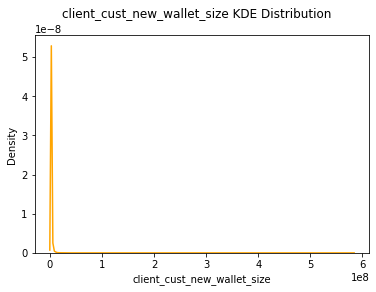

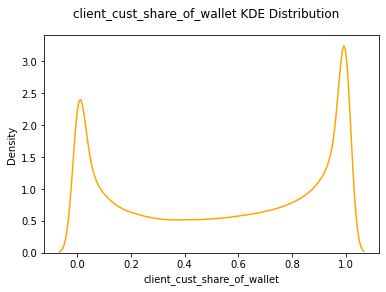

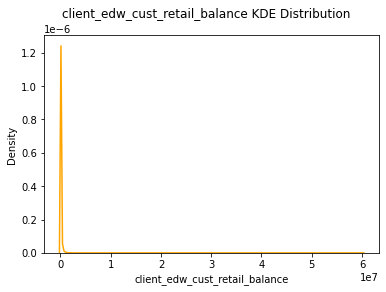

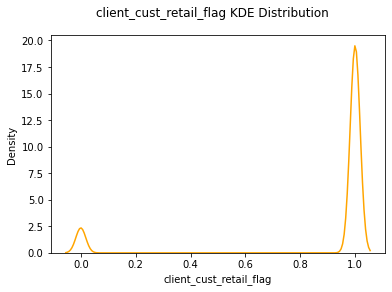

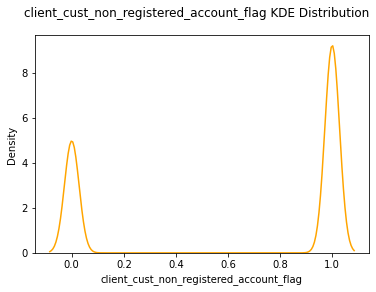

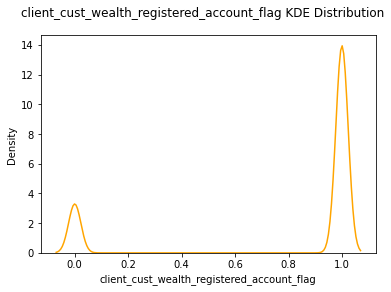

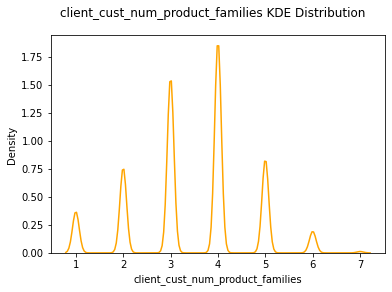

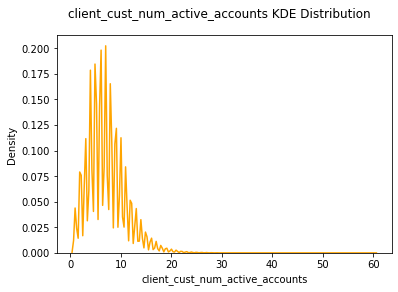

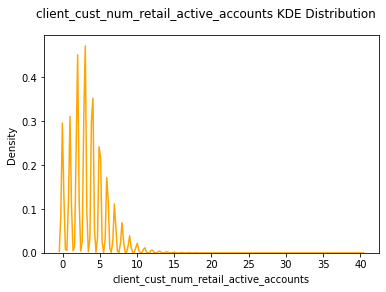

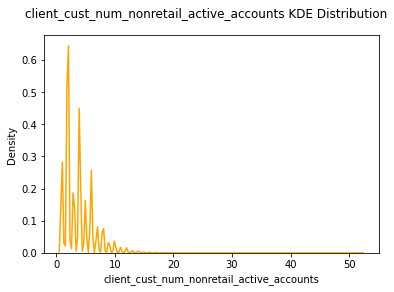

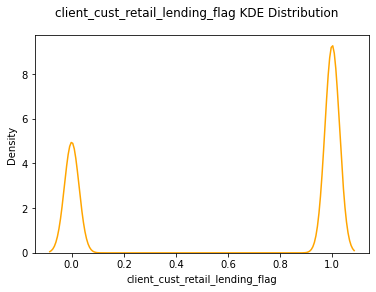

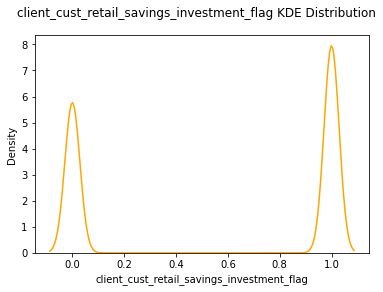

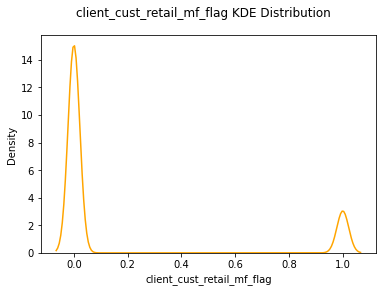

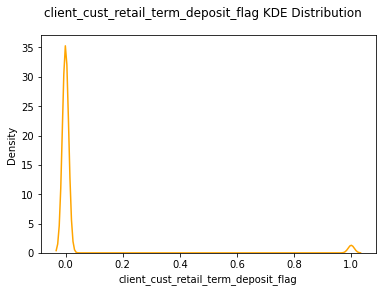

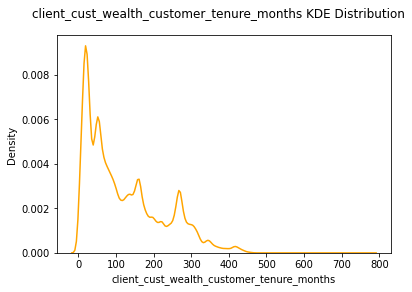

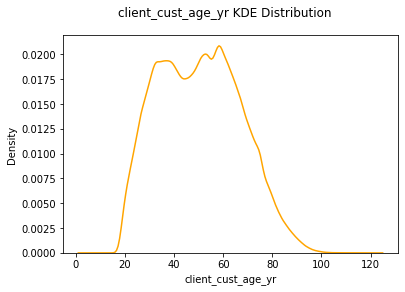

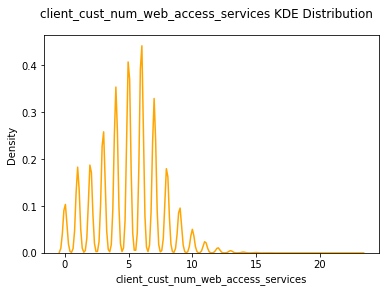

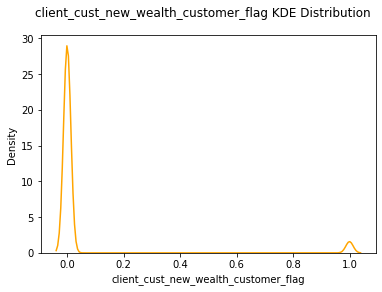

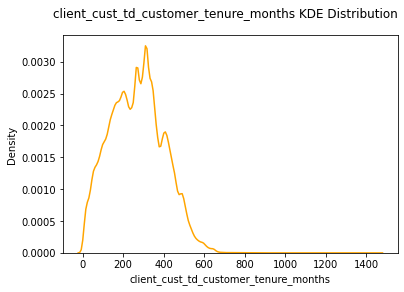

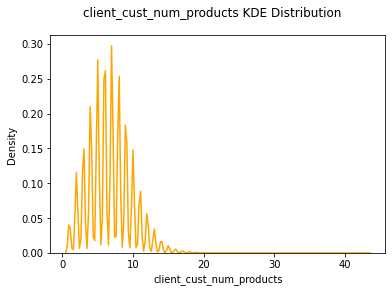

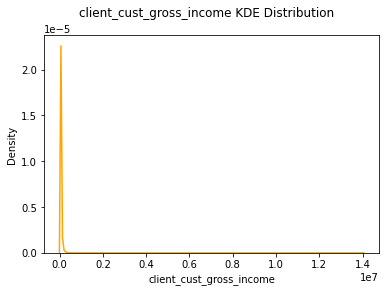

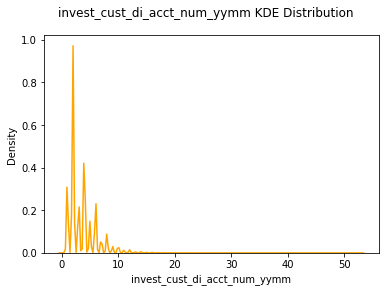

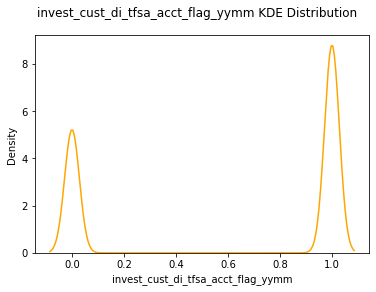

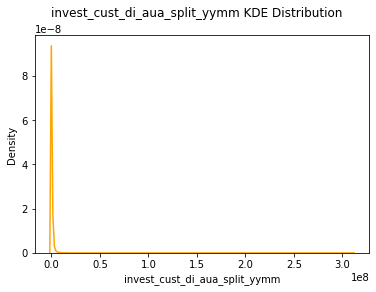

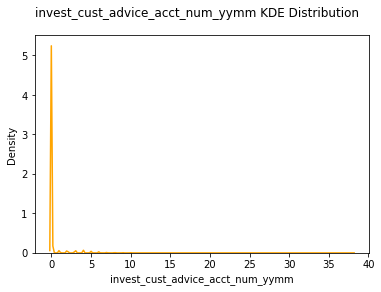

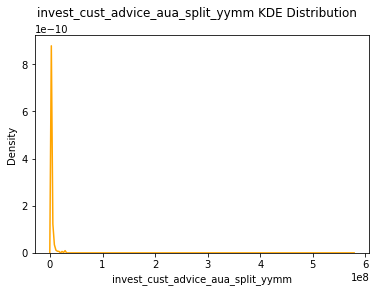

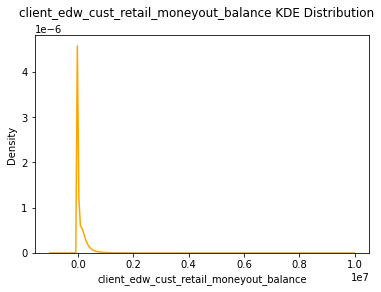

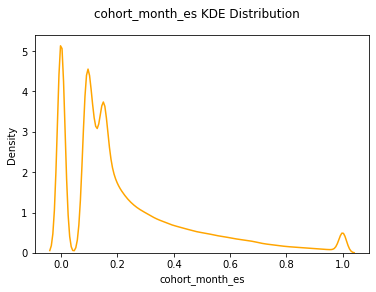

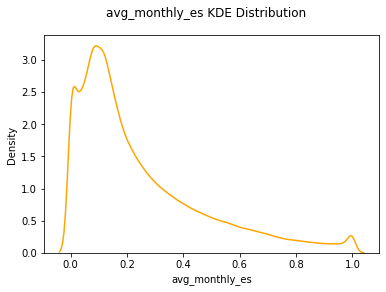

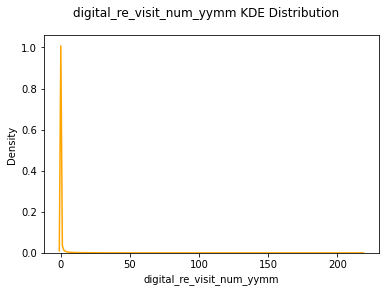

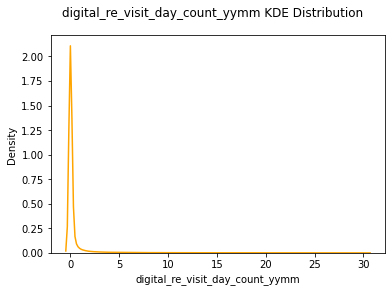

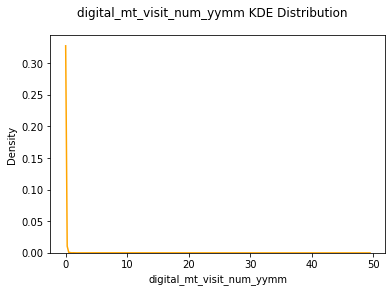

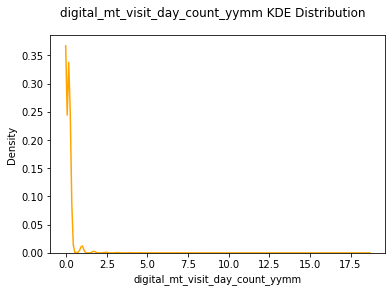

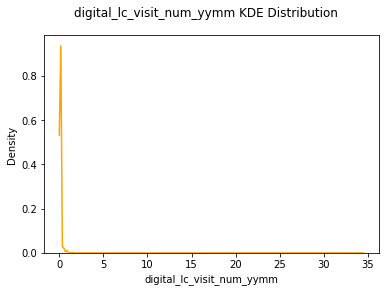

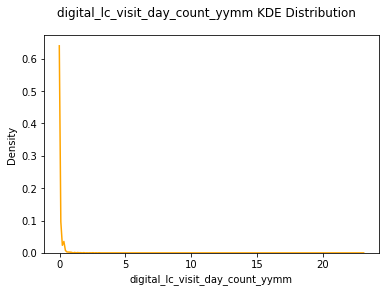

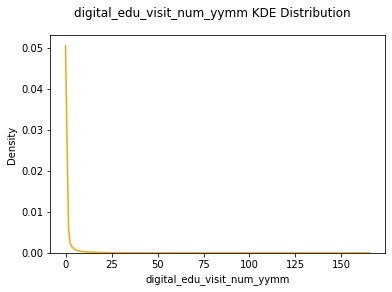

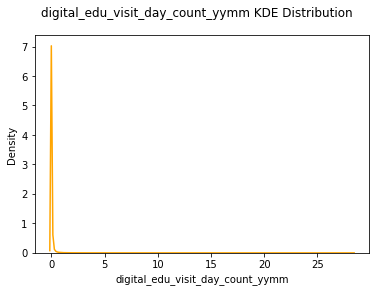

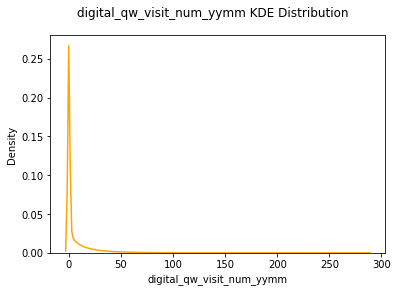

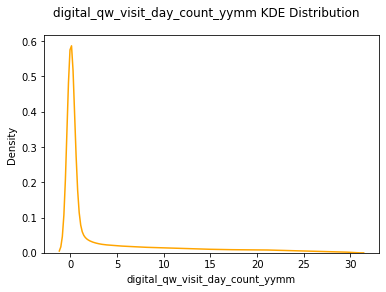

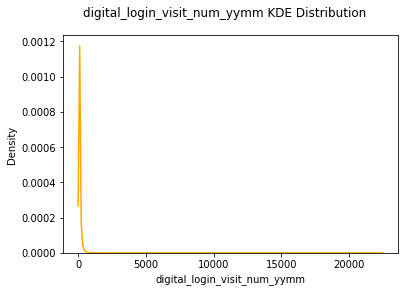

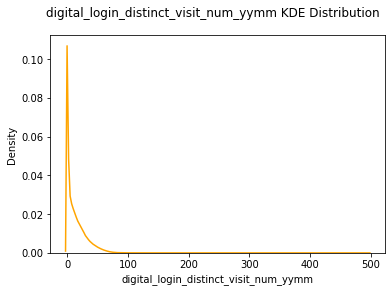

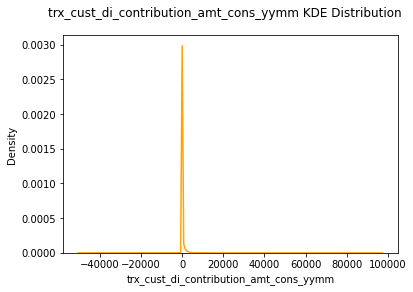

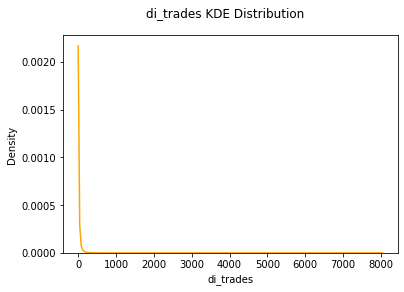

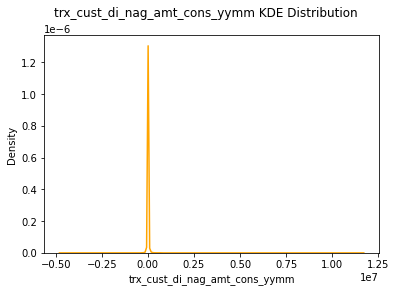

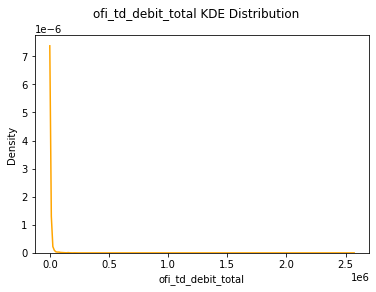

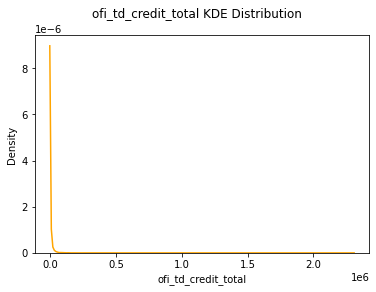

In [60]:
#Visualize the balancing: KDE plots for each feature

for feature in features_list:
    plt.close()
    fig, ax = plt.subplots()
    fig.suptitle('{} KDE Distribution'.format(feature))
    sns.kdeplot(data = df, x = df[feature], color='orange', ax = ax).set()
    plt.show()

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


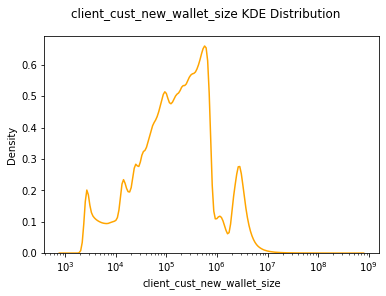

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


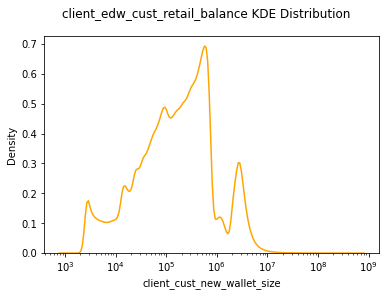

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-4ad4a92edb4a>:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x = df[df[feature] != 0]['client_cust_new_wallet_size'], log_scale=True, color='orange', ax = ax).set()


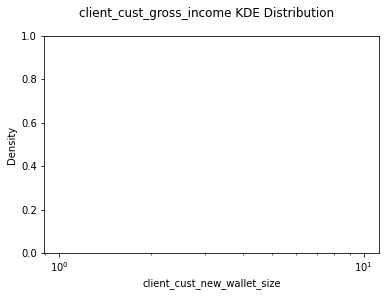

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


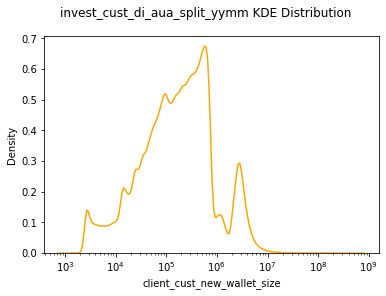

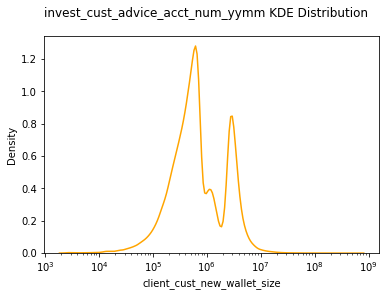

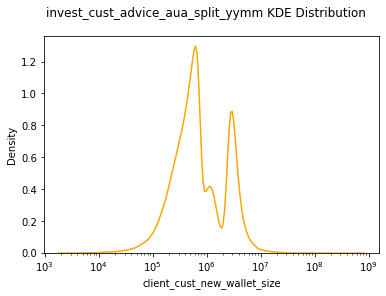

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-4ad4a92edb4a>:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x = df[df[feature] != 0]['client_cust_new_wallet_size'], log_scale=True, color='orange', ax = ax).set()


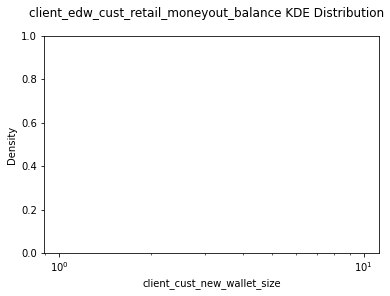

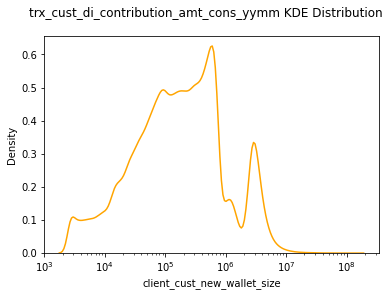

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


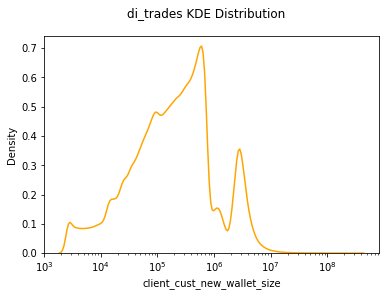

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


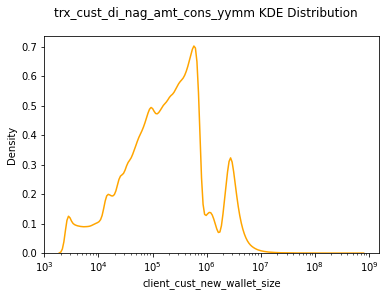

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


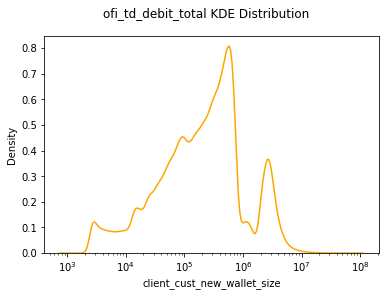

/opt/anaconda/anaconda-nb-2020.07/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


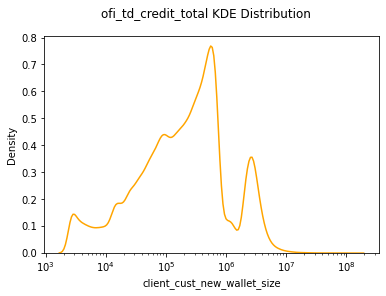

In [72]:
#For features where a log scale is appropriate (visual check from base KDE)
log_kde_features = [
    'client_cust_new_wallet_size'
    ,'client_edw_cust_retail_balance'
    ,'client_cust_gross_income'
    ,'invest_cust_di_aua_split_yymm'
    , 'invest_cust_advice_acct_num_yymm'
    , 'invest_cust_advice_aua_split_yymm'
    , 'client_edw_cust_retail_moneyout_balance'
    , 'trx_cust_di_contribution_amt_cons_yymm'
    , 'di_trades'
    , 'trx_cust_di_nag_amt_cons_yymm'
    , 'ofi_td_debit_total'
    , 'ofi_td_credit_total'
    ]

for feature in log_kde_features:
    plt.close()
    fig, ax = plt.subplots()
    fig.suptitle('{} KDE Distribution'.format(feature))
    sns.kdeplot(data = df, x = df[df[feature] != 0]['client_cust_new_wallet_size'], log_scale=True, color='orange', ax = ax).set()
    plt.show()

<Axes: >

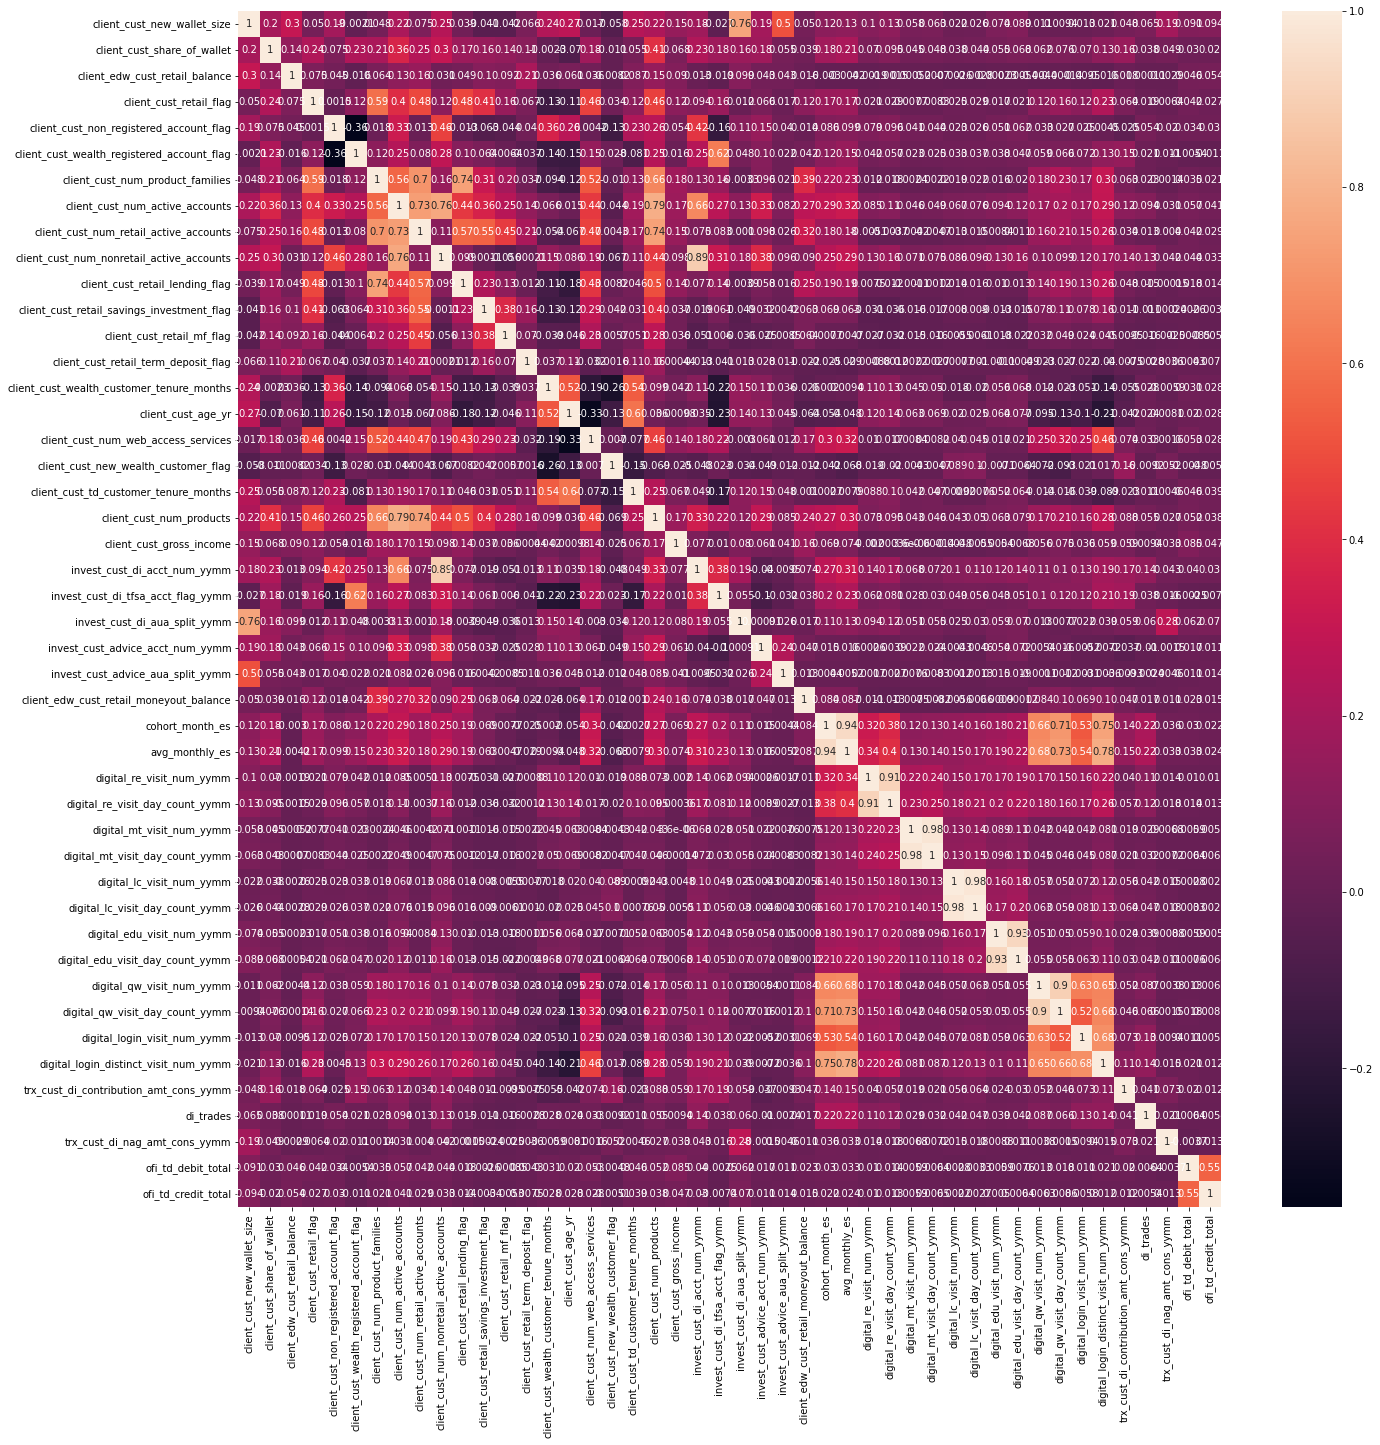

In [16]:
#Feature correlation matrix
plt.figure(figsize=(22, 22))
sns.heatmap(df[features_list].corr(), annot=True)

In [24]:
collinear_features_to_remove = [
    'client_cust_retail_lending_flag'
    ,'client_cust_num_nonretail_active_accounts'
    ,'client_cust_num_products'
    ,'client_cust_num_retail_active_accounts'
    ,'client_cust_new_wallet_size'
    ,'digital_qw_visit_day_count_yymm'
    ,'digital_login_distinct_visit_num_yymm'
    ,'avg_monthly_es'
    ,'digital_re_visit_day_count_yymm'
    ,'digital_mt_visit_day_count_yymm'
    ,'digital_lc_visit_day_count_yymm'
    ,'digital_edu_visit_day_count_yymm'
]

features_list_decollinear = [feature for feature in features_list if feature not in collinear_features_to_remove]

<Axes: >

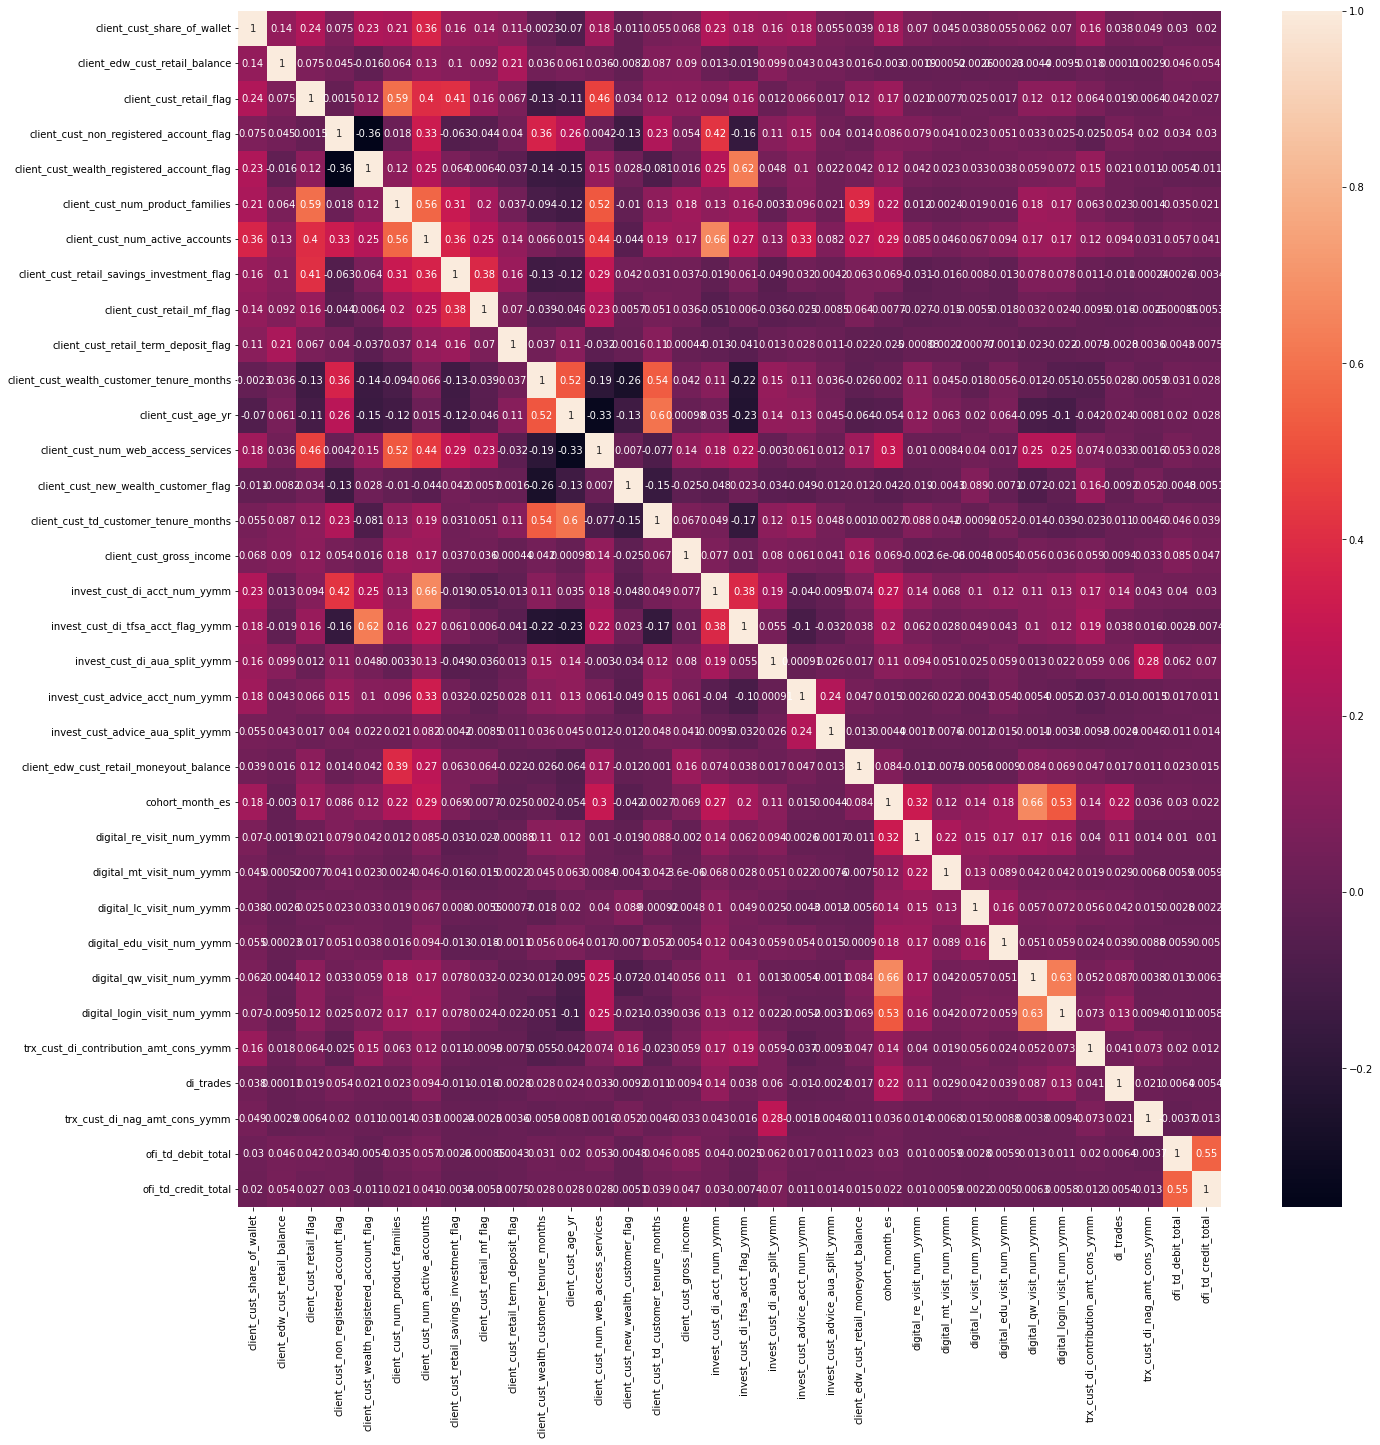

In [26]:
#update the features list with highly correlated ( > .7) features removed
plt.figure(figsize=(22, 22))
sns.heatmap(df[features_list_decollinear].corr(), annot=True)